STUTTERING DETECTION MODEL

In [5]:
## Stuttering event labels:

# Prolongation: Elongated syllable (e.g., M[mmm]ommy)
# Block: Gasps for air or stuttered pauses
# Sound Repetition: Repeated syllables (e.g., I [pr-pr-pr-]prepared dinner)
# Word Repetition: The same word or phrase is repeated (e.g., I made [made] dinner)
# No Stuttered Words: Confirmation that none of the above is true.
# Interjection: Common filler words such as "um" or "uh" or person-specific filler words that individuals use to cope with their stutter (e.g., some users frequently say "you know" as a filler).

In [6]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style 
style.use('ggplot')
import matplotlib.cm as cm
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold

import plotly.offline as py 
from plotly.offline import init_notebook_mode, iplot
py.init_notebook_mode(connected=True) # this allows us to work with offline plotly version
import plotly.graph_objs as go 


plt.rcParams['figure.figsize'] = (14, 6) #increase figure size

sns.set(style='white', font_scale=1.5) #set style

import warnings
warnings.filterwarnings('ignore')


#improve resolution
%config InlineBackend.figure_format ='retina'

In [7]:
df = pd.read_csv("/content/fluencybank_labels.csv")
df.sample(5)

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
349,FluencyBank,19,68,10628000,10676000,0,0,3,2,0,0,0,0,0,0,0,0
1720,FluencyBank,96,37,3560000,3608000,0,0,0,0,2,0,0,0,1,0,0,0
105,FluencyBank,16,5,1401600,1449600,1,0,1,1,0,0,0,0,1,1,0,0
3344,FluencyBank,178,169,7129440,7177440,0,0,1,0,0,0,0,3,2,0,0,0
2563,FluencyBank,111,96,629920,677920,0,0,0,0,0,0,0,0,3,0,0,0


In [8]:
df.columns

Index(['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality',
       'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand',
       'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music',
       'NoSpeech'],
      dtype='object')

In [9]:
## Value counts of stuttering

In [10]:
df['Prolongation'].value_counts()

0    3208
1     598
2     217
3     121
Name: Prolongation, dtype: int64

In [11]:
df['WordRep'].value_counts()

0    3204
1     510
3     226
2     204
Name: WordRep, dtype: int64

In [12]:
df['SoundRep'].value_counts()

0    2996
1     599
2     372
3     177
Name: SoundRep, dtype: int64

In [13]:
df['Name'] = df[df.columns[0:3]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)

In [14]:
df.columns

Index(['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality',
       'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand',
       'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music', 'NoSpeech',
       'Name'],
      dtype='object')

In [15]:
df.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Name
0,FluencyBank,10,0,88960,136960,0,0,0,1,0,0,0,0,2,0,0,0,FluencyBank_10_0
1,FluencyBank,10,1,1271520,1319520,0,0,0,0,0,0,0,0,3,0,0,0,FluencyBank_10_1
2,FluencyBank,10,2,1813760,1861760,0,0,1,0,0,0,0,0,2,0,0,0,FluencyBank_10_2
3,FluencyBank,10,3,1842720,1890720,0,0,1,0,0,0,0,0,2,1,0,0,FluencyBank_10_3
4,FluencyBank,10,4,1893280,1941280,0,0,0,0,0,3,0,0,0,0,0,0,FluencyBank_10_4


In [16]:
df['Name']


0          FluencyBank_10_0
1          FluencyBank_10_1
2          FluencyBank_10_2
3          FluencyBank_10_3
4          FluencyBank_10_4
               ...         
4139    FluencyBank_985_191
4140    FluencyBank_985_192
4141    FluencyBank_985_193
4142    FluencyBank_985_194
4143    FluencyBank_985_195
Name: Name, Length: 4144, dtype: object

In [17]:
df = df.sort_values(by='Name')
df.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Name
2285,FluencyBank,107,0,0,40480,0,0,0,0,0,0,0,0,3,0,0,0,FluencyBank_107_0
2286,FluencyBank,107,1,824160,872160,0,0,0,0,0,0,0,0,3,2,0,0,FluencyBank_107_1
2295,FluencyBank,107,10,1528160,1576160,0,0,0,2,1,0,0,0,0,0,0,0,FluencyBank_107_10
2296,FluencyBank,107,11,1550720,1598720,0,0,1,2,0,0,0,0,0,0,0,0,FluencyBank_107_11
2297,FluencyBank,107,12,1579360,1627360,0,0,1,0,0,0,0,0,2,0,0,0,FluencyBank_107_12


In [18]:
#MAKING DATASET FOR MACHINE LEARNING MODEL 

In [19]:
df['Stutter'] = df['WordRep'] + df['SoundRep'] + df['Prolongation'] + df['Interjection'] + df['Block']
df

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Name,Stutter
2285,FluencyBank,107,0,0,40480,0,0,0,0,0,0,0,0,3,0,0,0,FluencyBank_107_0,0
2286,FluencyBank,107,1,824160,872160,0,0,0,0,0,0,0,0,3,2,0,0,FluencyBank_107_1,0
2295,FluencyBank,107,10,1528160,1576160,0,0,0,2,1,0,0,0,0,0,0,0,FluencyBank_107_10,3
2296,FluencyBank,107,11,1550720,1598720,0,0,1,2,0,0,0,0,0,0,0,0,FluencyBank_107_11,3
2297,FluencyBank,107,12,1579360,1627360,0,0,1,0,0,0,0,0,2,0,0,0,FluencyBank_107_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,FluencyBank,99,95,6969280,7017280,0,0,0,1,1,2,0,1,0,0,0,0,FluencyBank_99_95,5
2195,FluencyBank,99,96,6998880,7046880,0,0,0,2,0,0,0,3,1,0,0,0,FluencyBank_99_96,5
2196,FluencyBank,99,97,498400,546400,0,0,0,0,0,3,0,3,0,0,0,0,FluencyBank_99_97,6
2197,FluencyBank,99,98,525600,573600,0,0,0,0,0,0,0,2,3,0,0,0,FluencyBank_99_98,2


In [20]:
df['Stutter'].value_counts()

0     1000
3      857
4      579
2      550
1      506
5      310
6      224
7       80
8       27
9       10
10       1
Name: Stutter, dtype: int64

In [21]:
df.loc[df['Stutter'] >= 1.0, 'Stutter'] = 1.0
df['Stutter'].value_counts()

1    3144
0    1000
Name: Stutter, dtype: int64

In [22]:
## Applying the model

tr_x = df.drop(columns = ['Stutter'])
tr_y = df.filter(['Stutter'])

In [23]:
tr_y

,Stutter
2285,0
2286,0
2295,1
2296,1
2297,1
...,...
2194,1
2195,1
2196,1
2197,1


Text(0.5, 0.98, ' Correlation Heatmap for Train dataset')

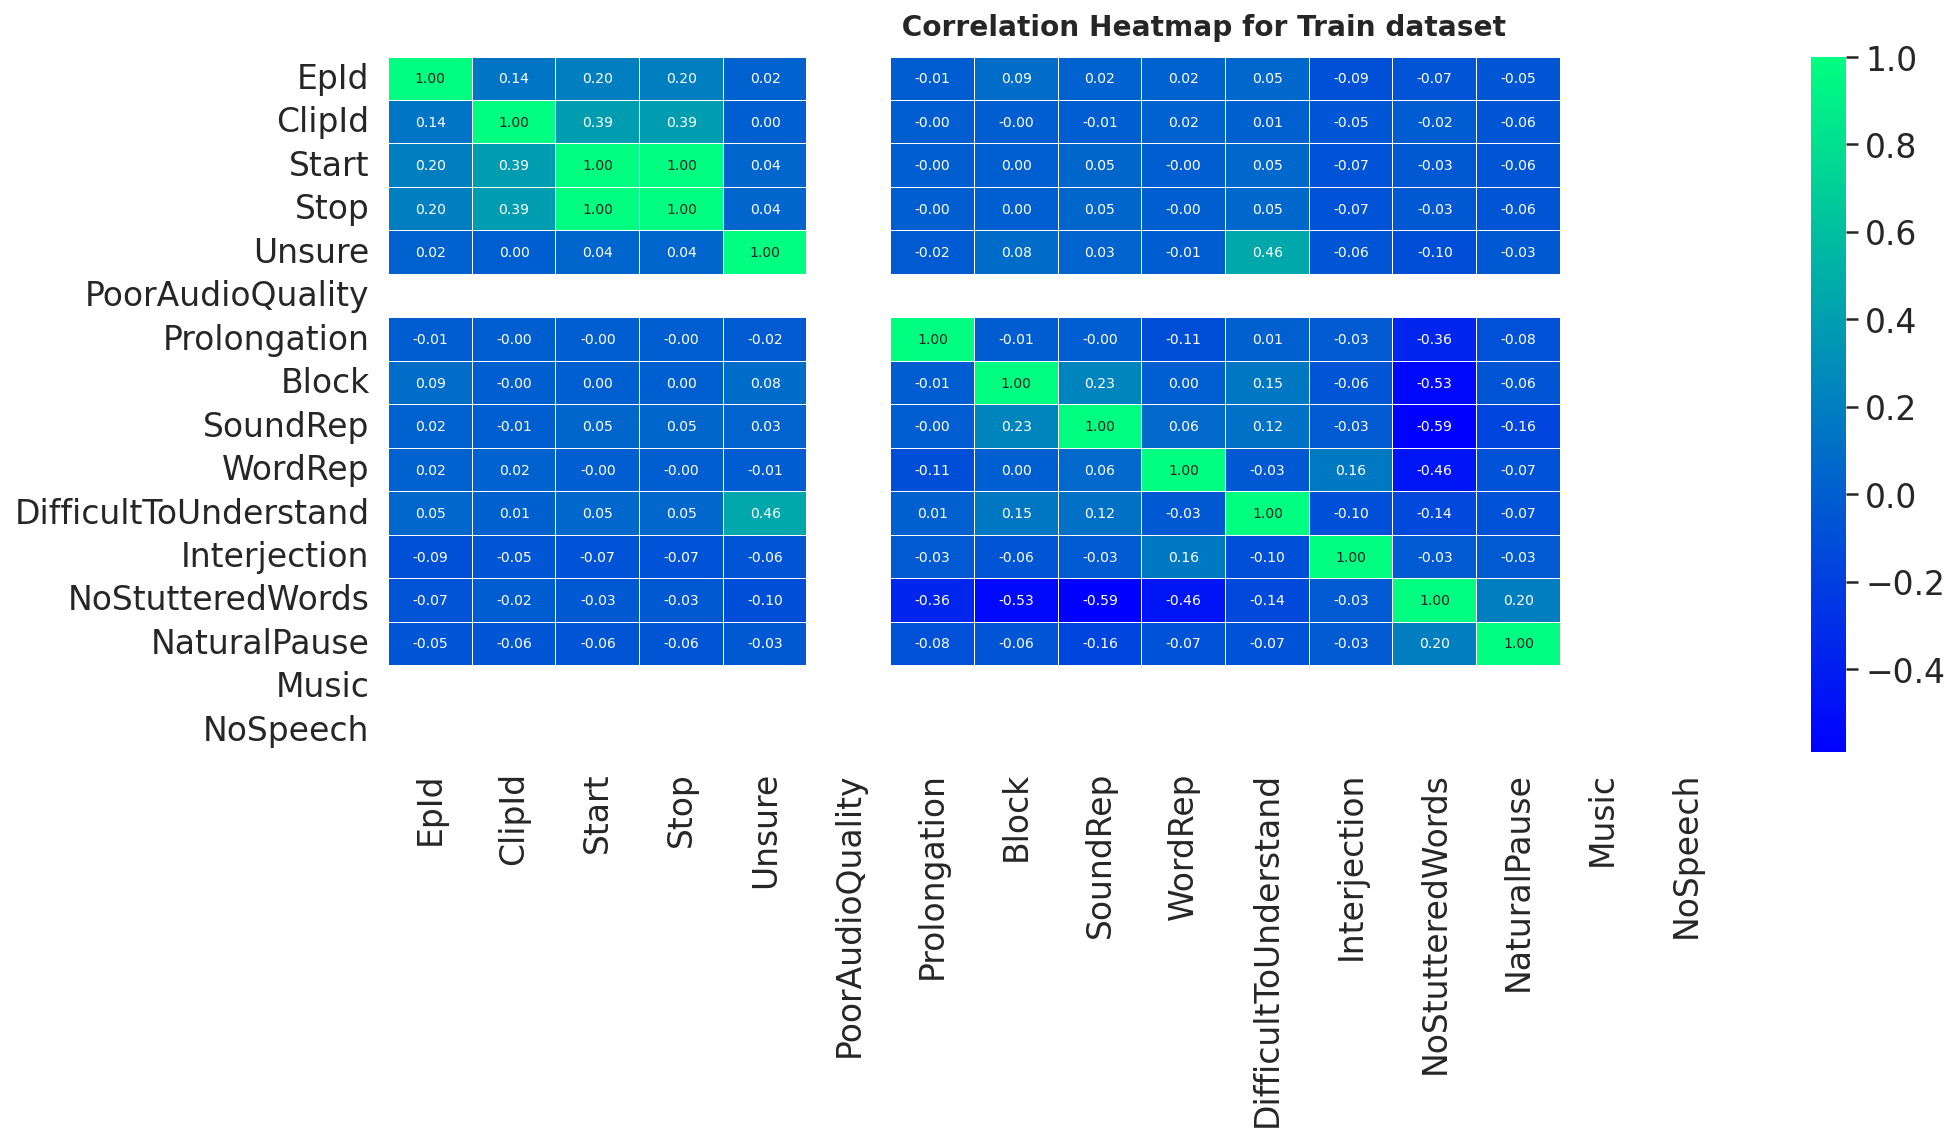

In [24]:
plt.rcParams.update({'figure.figsize': [15, 8], 'font.size': 7})
fig, ax = plt.subplots(1,1, figsize = (15,6))

hm = sns.heatmap(tr_x.iloc[:,0:].corr(),
                ax = ax,
                cmap = 'winter',
                annot = True,
                fmt = '.2f',
                linewidths = 0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle(' Correlation Heatmap for Train dataset', 
              fontsize=14, 
              fontweight='bold')

In [25]:
tr_x = df.drop(columns = ['Show', 'Name'])

from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaled_x = StandardScaler().fit_transform(tr_x)
scaled_x =pd.DataFrame(scaled_x) #Scaled training data

In [26]:
scaled_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.206568,-1.490566,-1.471677,-1.473764,-0.221299,0.0,-0.474537,-0.663308,-0.546980,-0.473180,-0.320857,-0.723940,1.139206,-0.495658,0.0,0.0,-1.773133
1,-0.206568,-1.468679,-1.241682,-1.241672,-0.221299,0.0,-0.474537,-0.663308,-0.546980,-0.473180,-0.320857,-0.723940,1.139206,3.508255,0.0,0.0,-1.773133
2,-0.206568,-1.271700,-1.045219,-1.045210,-0.221299,0.0,-0.474537,2.116011,0.662564,-0.473180,-0.320857,-0.723940,-1.270221,-0.495658,0.0,0.0,0.563974
3,-0.206568,-1.249813,-1.038923,-1.038914,-0.221299,0.0,0.935126,2.116011,-0.546980,-0.473180,-0.320857,-0.723940,-1.270221,-0.495658,0.0,0.0,0.563974
4,-0.206568,-1.227926,-1.030931,-1.030922,-0.221299,0.0,0.935126,-0.663308,-0.546980,-0.473180,-0.320857,-0.723940,0.336064,-0.495658,0.0,0.0,0.563974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4139,-0.247435,0.588662,0.473215,0.473216,-0.221299,0.0,-0.474537,0.726352,0.662564,1.984035,-0.320857,0.153255,-1.270221,-0.495658,0.0,0.0,0.563974
4140,-0.247435,0.610549,0.481475,0.481476,-0.221299,0.0,-0.474537,2.116011,-0.546980,-0.473180,-0.320857,1.907647,-0.467078,-0.495658,0.0,0.0,0.563974
4141,-0.247435,0.632435,-1.332590,-1.332580,-0.221299,0.0,-0.474537,-0.663308,-0.546980,3.212642,-0.320857,1.907647,-1.270221,-0.495658,0.0,0.0,0.563974
4142,-0.247435,0.654322,-1.325000,-1.324989,-0.221299,0.0,-0.474537,-0.663308,-0.546980,-0.473180,-0.320857,1.030451,1.139206,-0.495658,0.0,0.0,0.563974


In [27]:
tr = pd.concat([scaled_x, tr_y], axis = 1)

In [28]:
from sklearn.model_selection import train_test_split
fl_train, fl_test, fl_train_label, fl_test_label = train_test_split(tr_x, tr_y, train_size=0.80, random_state= 23, stratify = tr_y)
fl_train

,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Stutter
3341,178,166,7010880,7058880,0,0,0,0,0,0,0,3,3,0,0,0,1
3435,193,1,2965120,3013120,0,0,0,0,0,0,0,0,3,0,0,0,0
2844,121,99,5545280,5593280,0,0,0,0,0,0,0,0,3,0,0,0,0
1204,81,36,1498240,1546240,0,0,0,0,2,0,0,0,1,0,0,0,1
10,10,10,2112480,2160480,0,0,0,0,0,0,0,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,17,59,2500000,2548000,0,0,0,0,0,0,0,0,3,0,0,0,0
345,19,64,10072960,10120960,0,0,0,1,0,0,0,2,2,1,0,0,1
535,24,165,9601600,9649600,0,0,0,0,0,2,0,3,1,0,0,0,1
3869,230,99,5117760,5165760,0,0,0,0,0,0,0,3,3,0,0,0,1


In [29]:
fl_train_label

,Stutter
3341,1
3435,0
2844,0
1204,1
10,0
...,...
274,0
345,1
535,1
3869,1


In [30]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy_scores = np.zeros(5)

# Support Vector Classifier
clf = SVC().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[0] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'Support Vector Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[0]))

# Logistic Regression
clf = LogisticRegression(max_iter=10000).fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[1] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'Logistic Regression accuracy:'+'\033[0m','{}%'.format(accuracy_scores[1]))

# K Nearest Neighbors
clf = KNeighborsClassifier().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[2] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'K Nearest Neighbors Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[2]))

# Adaboost
clf = AdaBoostClassifier().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[3] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'Adaboost Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[3]))

# RandomForestClassifier
clf = RandomForestClassifier().fit(fl_train, fl_train_label.values.ravel())
prediction = clf.predict(fl_test)
accuracy_scores[4] = accuracy_score(fl_test_label, prediction)*100
print('\033[1m'+'RandomForest Classifier accuracy:'+'\033[0m','{}%'.format(accuracy_scores[4]))

Support Vector Classifier accuracy: 75.8745476477684%
Logistic Regression accuracy: 75.8745476477684%
K Nearest Neighbors Classifier accuracy: 70.80820265379975%
Adaboost Classifier accuracy: 100.0%
RandomForest Classifier accuracy: 100.0%


Text(0, 0.5, 'Accuracy after speedrun')

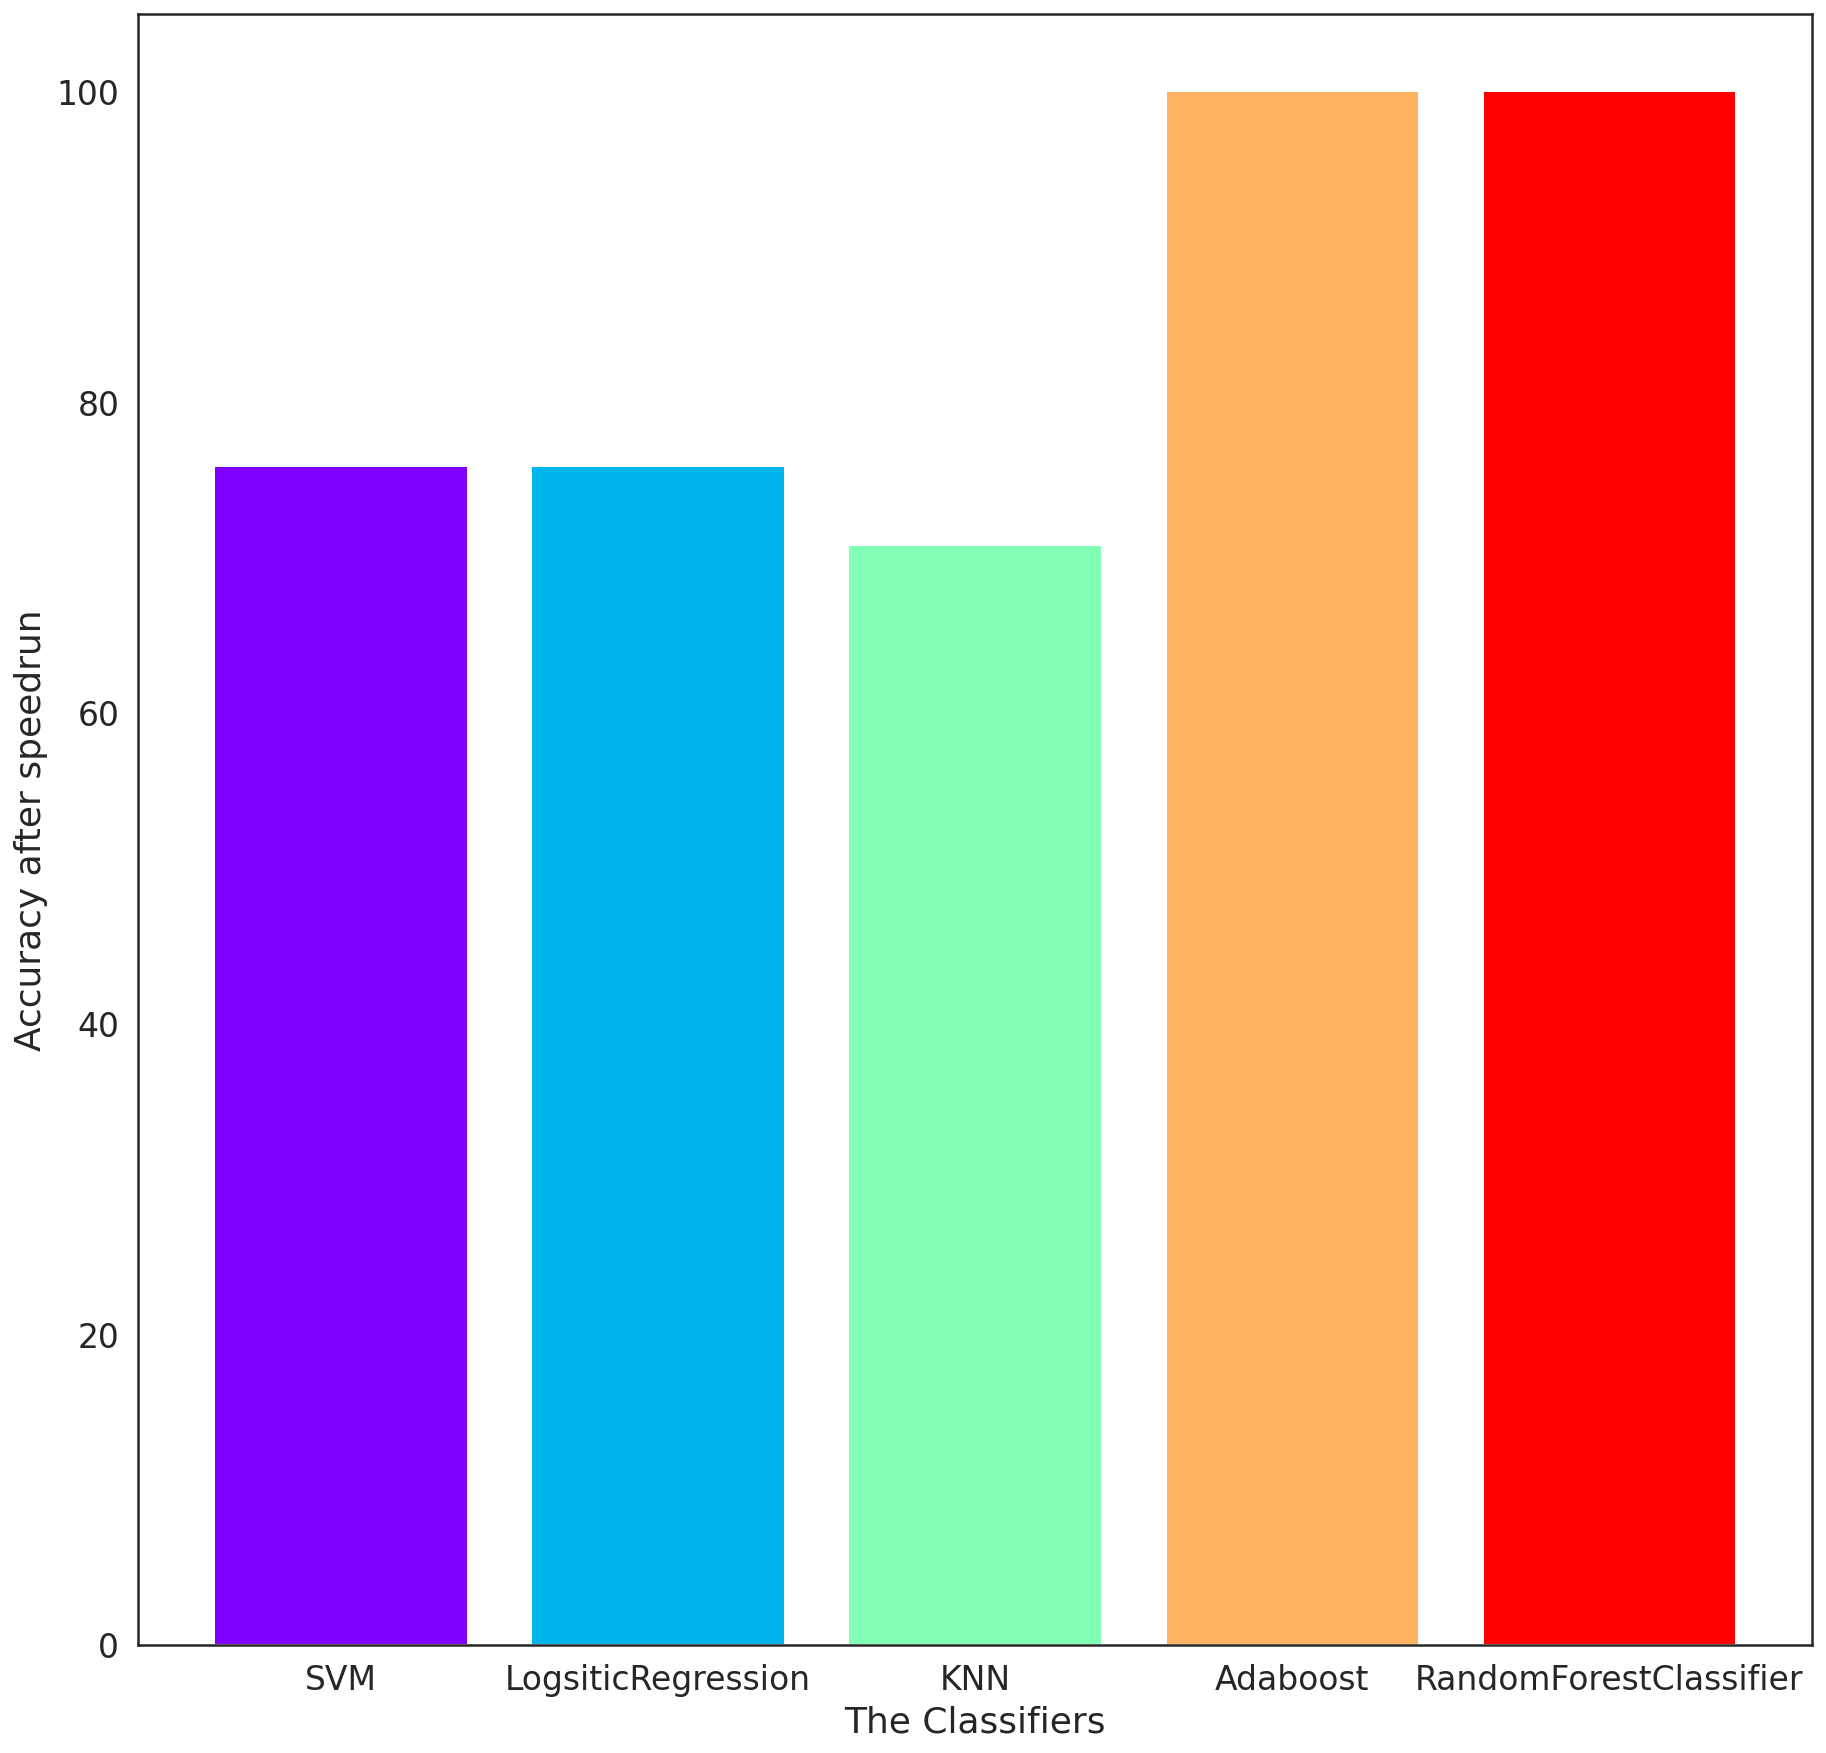

In [31]:
plt.rcParams.update({'figure.figsize': [15, 15], 'font.size': 12})
colors = cm.rainbow(np.linspace(0, 1, 5))
labels = ['SVM', 'LogsiticRegression', 'KNN', 'Adaboost', 'RandomForestClassifier' ]
plt.bar(labels,
        accuracy_scores[:5],
        color = colors)
plt.xlabel('The Classifiers')
plt.ylabel('Accuracy after speedrun')

(Check the accuracy)
